In [ ]:
!pip install fluidsynth
!pip install --upgrade fluidsynth
!pip install pretty_midi

In [ ]:
import collections
import datetime
import fluidsynth
import glob
import numpy as np
import pathlib
import pandas as pd
import pretty_midi
import seaborn as sns
import tensorflow as tf
from collections import Counter

from IPython import display
from matplotlib import pyplot as plt
from typing import Optional

In [ ]:
import zipfile
import os

zip_path = 'POP909.zip'       # Path to your zip file
extract_to = 'content'       # Folder to extract into

# Create the output directory if it doesn't exist
os.makedirs(extract_to, exist_ok=True)

# Extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print(f"Extracted '{zip_path}' to '{extract_to}'")

Extracted 'POP909.zip' to 'content'


In [ ]:
def find_midi_files(root_dir):
    midi_files = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        for filename in filenames:
            if filename.lower().endswith('.mid') or filename.lower().endswith('.midi'):
                midi_files.append(os.path.join(dirpath, filename))
    return midi_files

In [ ]:
def get_first_instrument_name(midi_path):
    try:
        pm = pretty_midi.PrettyMIDI(midi_path)
        if len(pm.instruments) == 0:
            return "None"
        instrument = pm.instruments[0]
        if instrument.is_drum:
            return "Drums"
        return pretty_midi.program_to_instrument_name(instrument.program)
    except Exception as e:
        print(f"Error processing {midi_path}: {e}")
        return "Error"

In [ ]:
def display_audio(pm: pretty_midi.PrettyMIDI, seconds=30):
  waveform = pm.fluidsynth(fs=_SAMPLING_RATE)
  # Take a sample of the generated waveform to mitigate kernel resets
  waveform_short = waveform[:seconds*_SAMPLING_RATE]
  return display.Audio(waveform_short, rate=_SAMPLING_RATE)

In [ ]:
def midi_to_notes(midi_file: str) -> pd.DataFrame:
  pm = pretty_midi.PrettyMIDI(midi_file)
  instrument = pm.instruments[0]
  notes = collections.defaultdict(list)

  # Sort the notes by start time
  sorted_notes = sorted(instrument.notes, key=lambda note: note.start)
  prev_start = sorted_notes[0].start

  for note in sorted_notes:
    start = note.start
    end = note.end
    notes['pitch'].append(note.pitch)
    notes['start'].append(start)
    notes['end'].append(end)
    notes['step'].append(start - prev_start)
    notes['duration'].append(end - start)
    prev_start = start

  return pd.DataFrame({name: np.array(value) for name, value in notes.items()})

In [ ]:
def notes_to_midi(
  notes: pd.DataFrame,
  out_file: str,
  instrument_name: str,
  velocity: int = 100,  # note loudness
) -> pretty_midi.PrettyMIDI:

  pm = pretty_midi.PrettyMIDI()
  instrument = pretty_midi.Instrument(
      program=pretty_midi.instrument_name_to_program(
          instrument_name))

  prev_start = 0
  for i, note in notes.iterrows():
    start = float(prev_start + note['step'])
    end = float(start + note['duration'])
    note = pretty_midi.Note(
        velocity=velocity,
        pitch=int(note['pitch']),
        start=start,
        end=end,
    )
    instrument.notes.append(note)
    prev_start = start

  pm.instruments.append(instrument)
  pm.write(out_file)
  return pm

In [ ]:
def create_sequences(
    dataset: tf.data.Dataset,
    seq_length: int,
    vocab_size = 128,
) -> tf.data.Dataset:
  """Returns TF Dataset of sequence and label examples."""
  seq_length = seq_length+1

  # Take 1 extra for the labels
  windows = dataset.window(seq_length, shift=1, stride=1,
                              drop_remainder=True)

  # `flat_map` flattens the" dataset of datasets" into a dataset of tensors
  flatten = lambda x: x.batch(seq_length, drop_remainder=True)
  sequences = windows.flat_map(flatten)

  # Normalize note pitch
  def scale_pitch(x):
    x = x/[vocab_size,1.0,1.0]
    return x

  # Split the labels
  def split_labels(sequences):
    inputs = sequences[:-1]
    labels_dense = sequences[-1]
    labels = {key:labels_dense[i] for i,key in enumerate(key_order)}

    return scale_pitch(inputs), labels

  return sequences.map(split_labels, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
def mse_with_positive_pressure(y_true: tf.Tensor, y_pred: tf.Tensor):
  mse = (y_true - y_pred) ** 2
  positive_pressure = 10 * tf.maximum(-y_pred, 0.0)
  return tf.reduce_mean(mse + positive_pressure)

In [ ]:
def predict_next_note(
    notes: np.ndarray,
    model: tf.keras.Model,
    temperature: float = 1.0) -> tuple[int, float, float]:
  """Generates a note as a tuple of (pitch, step, duration), using a trained sequence model."""

  assert temperature > 0

  # Add batch dimension
  inputs = tf.expand_dims(notes, 0)

  predictions = model.predict(inputs)
  pitch_logits = predictions['pitch']
  step = predictions['step']
  duration = predictions['duration']

  pitch_logits /= temperature
  pitch = tf.random.categorical(pitch_logits, num_samples=1)
  pitch = tf.squeeze(pitch, axis=-1)
  duration = tf.squeeze(duration, axis=-1)
  step = tf.squeeze(step, axis=-1)

  # `step` and `duration` values should be non-negative
  step = tf.maximum(0, step)
  duration = tf.maximum(0, duration)

  return int(pitch), float(step), float(duration)

In [ ]:
# Sampling rate for audio playback
_SAMPLING_RATE = 16000

root_folder = 'content/POP909'
all_files = find_midi_files(root_folder)

print(f"Found {len(all_files)} MIDI files")

num_files_to_check = 50

limited_files = all_files[:num_files_to_check]

sample_file = 'content/POP909/703/703.mid'  # or another path from your dataset

raw_notes = midi_to_notes(sample_file)
print(raw_notes.head())

epochs = 30

# Sampling rate for audio playback
_SAMPLING_RATE = 16000

root_folder = 'content/POP909'
all_files = find_midi_files(root_folder)

print(f"Found {len(all_files)} MIDI files")

seq_length = 25
vocab_size = 128

Found 2898 MIDI files
   pitch      start        end      step  duration
0     69  16.615386  16.984617  0.000000  0.369231
1     71  17.076925  17.230771  0.461538  0.153846
2     71  17.307694  17.894232  0.230769  0.586539
3     62  18.230771  18.415386  0.923077  0.184615
4     74  18.461540  18.811540  0.230769  0.350000
Found 2898 MIDI files


In [ ]:
get_note_names = np.vectorize(pretty_midi.note_number_to_name)
sample_note_names = get_note_names(raw_notes['pitch'])
sample_note_names[:10]

array(['A4', 'B4', 'B4', 'D4', 'D5', 'D5', 'C5', 'B4', 'A4', 'A4'],
      dtype='<U3')

In [ ]:
all_notes = []

for f in all_files[:num_files_to_check]:
    notes = midi_to_notes(f)
    all_notes.append(notes)

all_notes = pd.concat(all_notes)
n_notes = len(all_notes)
print('Number of notes parsed:', n_notes)



/usr/local/lib/python3.11/dist-packages/pretty_midi/pretty_midi.py:100: RuntimeWarning: Tempo, Key or Time signature change events found on non-zero tracks.  This is not a valid type 0 or type 1 MIDI file.  Tempo, Key or Time Signature may be wrong.
  warnings.warn(


Number of notes parsed: 17283


In [ ]:
key_order = ['pitch', 'step', 'duration']
train_notes = np.stack([all_notes[key] for key in key_order], axis=1)
notes_ds = tf.data.Dataset.from_tensor_slices(train_notes)
notes_ds.element_spec

TensorSpec(shape=(3,), dtype=tf.float64, name=None)

In [ ]:
seq_ds = create_sequences(notes_ds, seq_length, vocab_size)
seq_ds.element_spec

(TensorSpec(shape=(25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(), dtype=tf.float64, name=None)})

In [ ]:
for seq, target in seq_ds.take(1):
  print('sequence shape:', seq.shape)
  print('sequence elements (first 10):', seq[0: 10])
  print()
  print('target:', target)

sequence shape: (25, 3)
sequence elements (first 10): tf.Tensor(
[[0.546875   0.         0.2147431 ]
 [0.546875   0.3846145  0.33974281]
 [0.609375   0.3846145  0.61378064]
 [0.6015625  0.769229   0.62019088]
 [0.6015625  1.1538435  0.27884551]
 [0.5859375  0.3846145  0.64583185]
 [0.578125   0.769229   0.69551122]
 [0.5859375  0.769229   1.32211234]
 [0.546875   2.6923015  0.28044807]
 [0.5546875  0.3846145  0.57531919]], shape=(10, 3), dtype=float64)

target: {'pitch': <tf.Tensor: shape=(), dtype=float64, numpy=74.0>, 'step': <tf.Tensor: shape=(), dtype=float64, numpy=0.7692290000000028>, 'duration': <tf.Tensor: shape=(), dtype=float64, numpy=1.3958301229166707>}


In [ ]:
batch_size = 64
buffer_size = n_notes - seq_length  # the number of items in the dataset
train_ds = (seq_ds
            .shuffle(buffer_size)
            .batch(batch_size, drop_remainder=True)
            .cache()
            .prefetch(tf.data.experimental.AUTOTUNE))

In [ ]:
train_ds.element_spec

(TensorSpec(shape=(64, 25, 3), dtype=tf.float64, name=None),
 {'pitch': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'step': TensorSpec(shape=(64,), dtype=tf.float64, name=None),
  'duration': TensorSpec(shape=(64,), dtype=tf.float64, name=None)})

In [ ]:
input_shape = (seq_length, 3)
learning_rate = 0.005

inputs = tf.keras.Input(input_shape)
x = tf.keras.layers.LSTM(128)(inputs)

outputs = {
  'pitch': tf.keras.layers.Dense(128, name='pitch')(x),
  'step': tf.keras.layers.Dense(1, name='step')(x),
  'duration': tf.keras.layers.Dense(1, name='duration')(x),
}

model = tf.keras.Model(inputs, outputs)

loss = {
      'pitch': tf.keras.losses.SparseCategoricalCrossentropy(
          from_logits=True),
      'step': mse_with_positive_pressure,
      'duration': mse_with_positive_pressure,
}

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)

model.compile(loss=loss, optimizer=optimizer)

model.summary()

Model: "functional_16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 25, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_16 (LSTM)      │ (None, 128)       │     67,584 │ input_layer_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ duration (Dense)    │ (None, 1)         │        129 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pitch (Dense)       │ (None, 128)       │     16,512 │ lstm_16[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ step (Dense)        │ (None, 1)         │        129 │ lstm_16[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 84,354 (329.51 KB)

 Trainable params: 84,354 (329.51 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
losses = model.evaluate(train_ds, return_dict=True)
losses

269/269 ━━━━━━━━━━━━━━━━━━━━ 8s 15ms/step - duration_loss: 0.3362 - loss: 7.2339 - pitch_loss: 4.8615 - step_loss: 2.0362


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.3201083540916443,
 'loss': 7.45965576171875,
 'pitch_loss': 4.843893527984619,
 'step_loss': 2.295654296875}

In [ ]:
model.compile(
    loss=loss,
    loss_weights={
        'pitch': 0.05,
        'step': 0.5,
        'duration':1.0,
    },
    optimizer=optimizer,
)

In [ ]:
model.evaluate(train_ds, return_dict=True)

269/269 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - duration_loss: 0.1563 - loss: 0.6641 - pitch_loss: 2.7952 - step_loss: 0.7360


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


{'duration_loss': 0.14738939702510834,
 'loss': 0.7335112690925598,
 'pitch_loss': 2.7739150524139404,
 'step_loss': 0.894852876663208}

In [ ]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/ckpt_{epoch}.weights.h5',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [ ]:
%%time
history = model.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
)

Epoch 1/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 13s 43ms/step - duration_loss: 0.1548 - loss: 0.6572 - pitch_loss: 2.7916 - step_loss: 0.7256
Epoch 2/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - duration_loss: 0.1527 - loss: 0.6471 - pitch_loss: 2.7722 - step_loss: 0.7116
Epoch 3/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 12s 43ms/step - duration_loss: 0.1514 - loss: 0.6416 - pitch_loss: 2.7511 - step_loss: 0.7053
Epoch 4/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - duration_loss: 0.1492 - loss: 0.6331 - pitch_loss: 2.7400 - step_loss: 0.6938
Epoch 5/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 10s 39ms/step - duration_loss: 0.1465 - loss: 0.6246 - pitch_loss: 2.7220 - step_loss: 0.6839
Epoch 6/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 11s 42ms/step - duration_loss: 0.1444 - loss: 0.6163 - pitch_loss: 2.7080 - step_loss: 0.6730
Epoch 7/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 43ms/step - duration_loss: 0.1425 - loss: 0.6230 - pitch_loss: 2.6989 - step_loss: 0.6911
Epoch 8/30
269/269 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - durati

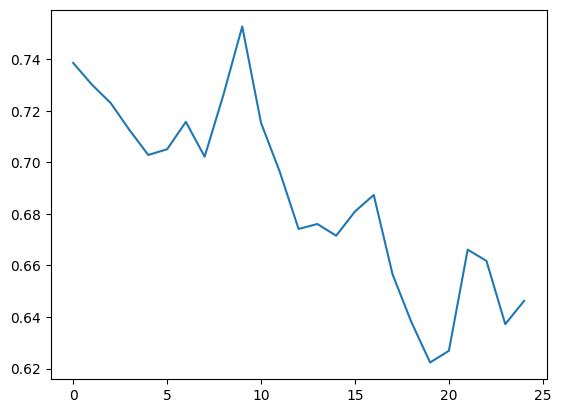

In [ ]:
plt.plot(history.epoch, history.history['loss'], label='total loss')
plt.show()

In [ ]:
temperature = 1.5
num_predictions = 120

sample_notes = np.stack([raw_notes[key] for key in key_order], axis=1)

# The initial sequence of notes; pitch is normalized similar to training
# sequences
input_notes = (
    sample_notes[:seq_length] / np.array([vocab_size, 1, 1]))

generated_notes = []
prev_start = 0
for _ in range(num_predictions):
  pitch, step, duration = predict_next_note(input_notes, model, temperature)
  start = prev_start + step
  end = start + duration
  input_note = (pitch, step, duration)
  generated_notes.append((*input_note, start, end))
  input_notes = np.delete(input_notes, 0, axis=0)
  input_notes = np.append(input_notes, np.expand_dims(input_note, 0), axis=0)
  prev_start = start

generated_notes = pd.DataFrame(
    generated_notes, columns=(*key_order, 'start', 'end'))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 225ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━

In [ ]:
generated_notes.head(10)

,pitch,step,duration,start,end
0,72,0.333237,0.390894,0.333237,0.724131
1,77,1.496174,0.395799,1.829410,2.225209
2,78,1.548178,0.439185,3.377588,3.816773
3,78,1.553071,0.442688,4.930659,5.373347
4,77,1.553531,0.443007,6.484191,6.927198
5,77,1.553893,0.443407,8.038084,8.481491
6,77,1.553949,0.443441,9.592033,10.035474
7,84,1.553952,0.443442,11.145985,11.589426
8,77,1.551612,0.441011,12.697597,13.138608
9,77,1.553616,0.443232,14.251213,14.694445


In [ ]:
out_file = 'output.mid'
instrument_name = 'Acoustic Grand Piano'
out_pm = notes_to_midi(
    generated_notes, out_file=out_file, instrument_name=instrument_name)